## Preparing Necessary Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u

import warnings
warnings.filterwarnings('ignore')

In [2]:
fits_path = '/home/rabbit/PSF_BuildUp/FITS_images/KIDS_9.5_-33.1.fits'
hdul = fits.open(fits_path, memmap=True)
image_data = hdul[0].data
wcs = WCS(hdul[0].header)

base_dir = '/home/rabbit/PSF_BuildUp/'
query_results_dir = os.path.join(base_dir, 'Query_results')
os.makedirs(query_results_dir, exist_ok=True)

gaia_dir = os.path.join(query_results_dir, 'gaia')
os.makedirs(gaia_dir, exist_ok=True)

In [3]:
cat_file = '/home/rabbit/PSF_BuildUp/FITS_images/se_in_out/outparams_KIDS_9.5_-33.1.cat'

catalog = pd.read_csv(
    cat_file,
    sep='\s+',              
    comment='#',
    names=['NUMBER', 'MAG_AUTO', 'MAGERR_AUTO', 'X_IMAGE', 'Y_IMAGE', 
           'FLAGS', 'ELLIPTICITY', 'CLASS_STAR', 'FLUX_RADIUS'],
    usecols=['NUMBER', 'X_IMAGE', 'Y_IMAGE', 'MAG_AUTO', 'FLUX_RADIUS', 'CLASS_STAR'],  
    index_col=False
)

x_pix = catalog['X_IMAGE'].values
y_pix = catalog['Y_IMAGE'].values

sky_coords = wcs.pixel_to_world(x_pix, y_pix)
catalog['RA_deg'] = sky_coords.ra.deg
catalog['Dec_deg'] = sky_coords.dec.deg

catalog_psf = catalog[catalog['CLASS_STAR'] >= 0.84].copy()
output_file = '/home/rabbit/PSF_BuildUp/Query_results/wcs_corrected_KIDS_9.5_-33.1_psf_sextractor.cat'
catalog_psf.to_csv(output_file, index=False)

print(f"Saved catalog for PSF stars to {output_file}")
print(f"Number of PSF stars saved: {len(catalog_psf)}")

Saved catalog for PSF stars to /home/rabbit/PSF_BuildUp/Query_results/wcs_corrected_KIDS_9.5_-33.1_psf_sextractor.cat
Number of PSF stars saved: 5893


In [4]:
print(hdul.info())
print(WCS(hdul[0].header))

Filename: /home/rabbit/PSF_BuildUp/FITS_images/KIDS_9.5_-33.1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      85   (18711, 20033)   float32   
None
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN'
CUNIT : 'deg' 'deg'
CRVAL : 9.504950495 -33.13736264
CRPIX : 9334.0 10038.0
CD1_1 CD1_2  : -5.555555638e-05 0.0
CD2_1 CD2_2  : 0.0 5.555555638e-05
NAXIS : 18711  20033


In [5]:
cat_file_wcs = '/home/rabbit/PSF_BuildUp/Query_results/wcs_corrected_KIDS_9.5_-33.1_psf_sextractor.cat'


catalog = pd.read_csv(cat_file_wcs)
catalog = catalog[['NUMBER', 'RA_deg', 'Dec_deg', 'MAG_AUTO', 'FLUX_RADIUS']]

coords = SkyCoord(ra=catalog['RA_deg'].values*u.deg,
                  dec=catalog['Dec_deg'].values*u.deg)

print(f"Loaded catalog with {len(catalog)} stars")
print(catalog.sample(20).to_string(index=False))

Loaded catalog with 5893 stars
 NUMBER    RA_deg    Dec_deg  MAG_AUTO  FLUX_RADIUS
   8359  9.673690 -33.382303   22.7384        1.791
   9645  9.851854 -33.334658   22.9547        2.199
  22590  9.735783 -32.978508   22.7104        1.901
   3913  9.468541 -33.544841   23.3179        1.558
   1298  9.667341 -33.643698   16.6504        2.125
    832  9.801915 -33.664574   23.1145        2.003
  17020  9.452074 -33.066140   18.9104        1.995
   7965  8.934761 -33.391568   17.1728        2.313
  15672  8.925317 -33.102218   14.2737        3.656
  12815  9.643667 -33.219834   22.1097        1.783
  25811  9.665694 -32.658133   15.8794        2.169
  13128  8.920629 -33.201613   16.3499        2.332
  29265  9.055282 -32.803672   21.1045        2.302
   7092  9.074167 -33.428058   20.4574        2.075
  29391  9.333821 -32.793600   23.0112        1.987
  10797  8.954630 -33.289718   21.6906        2.209
   3758  9.572441 -33.550203   22.5811        1.867
   2302 10.000507 -33.602989   15

## Astroquery using GAIA

In [6]:
fits_path = '/home/rabbit/PSF_BuildUp/FITS_images/KIDS_9.5_-33.1.fits'
output_file = '/home/rabbit/PSF_BuildUp/Query_results/gaia/gaia_sources.csv'

hdul = fits.open(fits_path, memmap=True)
wcs = WCS(hdul[0].header)
header = hdul[0].header
nx = hdul[0].header['NAXIS1']
ny = hdul[0].header['NAXIS2']

pixscale = 0.2 / 3600 

width = nx * pixscale * u.deg
height = ny * pixscale * u.deg
ra_center = header['CRVAL1']  
dec_center = header['CRVAL2'] 

coord_center = SkyCoord(ra=ra_center, dec=dec_center, unit='deg', frame='icrs')

print(f"Query center: RA={ra_center:.6f}, Dec={dec_center:.6f}")
print(f"Rectangle width={width}, height={height}")

Gaia.ROW_LIMIT = -1
query = Gaia.query_object_async(
    coordinate=coord_center,
    width=width,
    height=height,
)

print(f"Retrieved {len(query)} Gaia sources")
query.write(output_file, format='csv', overwrite=True)
print(f"Saved Gaia query result to {output_file}")

Query center: RA=9.504950, Dec=-33.137363
Rectangle width=1.0395 deg, height=1.1129444444444445 deg
INFO: Query finished. [astroquery.utils.tap.core]
Retrieved 2803 Gaia sources
Saved Gaia query result to /home/rabbit/PSF_BuildUp/Query_results/gaia/gaia_sources.csv


In [7]:
psf_cat_file = '/home/rabbit/PSF_BuildUp/Query_results/wcs_corrected_KIDS_9.5_-33.1_psf_sextractor.cat'
gaia_file = '/home/rabbit/PSF_BuildUp/Query_results/gaia/gaia_sources.csv'
output_file = '/home/rabbit/PSF_BuildUp/Query_results/gaia/gaia_matched_psf.csv'

catalog_psf = pd.read_csv(psf_cat_file)
catalog_psf['RA_deg'] = catalog_psf['RA_deg'].astype(float)
catalog_psf['Dec_deg'] = catalog_psf['Dec_deg'].astype(float)

gaia_catalog = pd.read_csv(gaia_file)
gaia_catalog['ra'] = gaia_catalog['ra'].astype(float)
gaia_catalog['dec'] = gaia_catalog['dec'].astype(float)

coords_psf = SkyCoord(ra=catalog_psf['RA_deg'].values * u.deg,
                      dec=catalog_psf['Dec_deg'].values * u.deg)
coords_gaia = SkyCoord(ra=gaia_catalog['ra'].values * u.deg,
                       dec=gaia_catalog['dec'].values * u.deg)
idx, d2d, _ = coords_psf.match_to_catalog_sky(coords_gaia)
max_sep = 1.5 * u.arcsec
matches = d2d < max_sep

star_mask = gaia_catalog.loc[idx[matches], 'classprob_dsc_combmod_star'] >= 0.98
final_matches = matches.copy()
final_matches[matches] = star_mask.values

matched_catalog = catalog_psf[final_matches].copy()
matched_catalog['GAIA_RA'] = gaia_catalog.loc[idx[final_matches], 'ra'].values
matched_catalog['GAIA_Dec'] = gaia_catalog.loc[idx[final_matches], 'dec'].values
matched_catalog['GAIA_Gmag'] = gaia_catalog.loc[idx[final_matches], 'phot_g_mean_mag'].values  
matched_catalog['GAIA_StarProb'] = gaia_catalog.loc[idx[final_matches], 'classprob_dsc_combmod_star'].values  
matched_catalog['Separation_arcsec'] = d2d[final_matches].arcsec

matched_catalog.to_csv(output_file, index=False, float_format='%.3f')
print(f"Saved matched catalog to {output_file}")
print(f"Number of Gaia-confirmed stars: {len(matched_catalog)}")

Saved matched catalog to /home/rabbit/PSF_BuildUp/Query_results/gaia/gaia_matched_psf.csv
Number of Gaia-confirmed stars: 2244


Matched PSF stars: 2244
Unmatched PSF stars: 3649


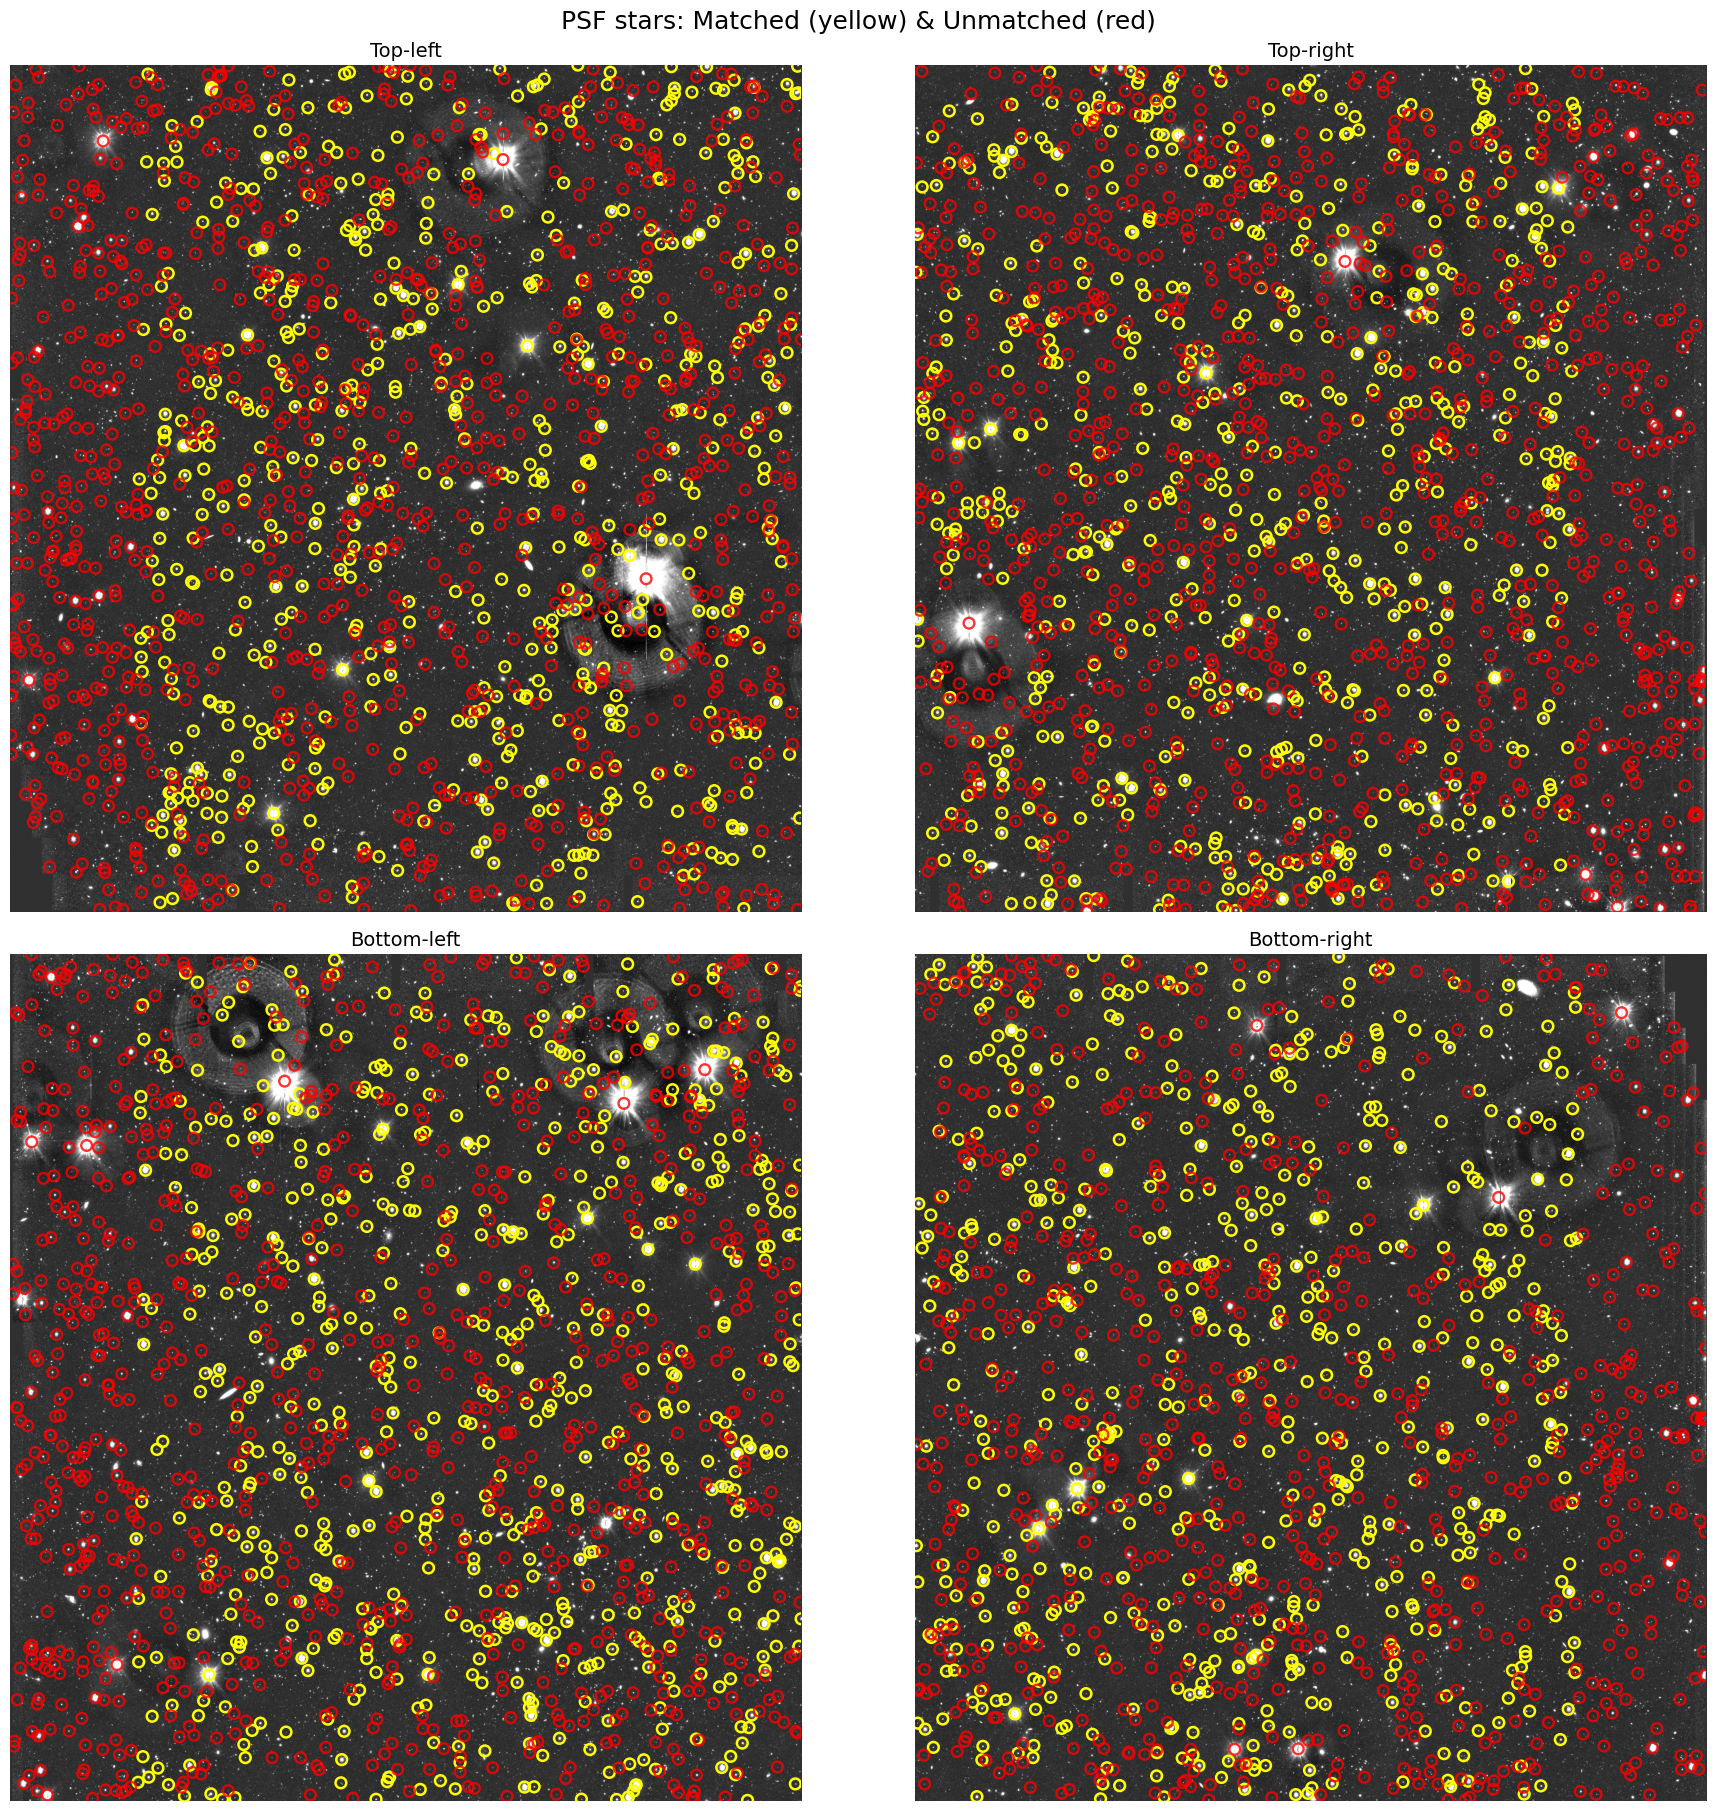

In [8]:
fits_path = '/home/rabbit/PSF_BuildUp/FITS_images/KIDS_9.5_-33.1.fits'
matched_file = '/home/rabbit/PSF_BuildUp/Query_results/gaia/gaia_matched_psf.csv'
full_psf_file = '/home/rabbit/PSF_BuildUp/Query_results/wcs_corrected_KIDS_9.5_-33.1_psf_sextractor.cat'

psf_full = pd.read_csv(full_psf_file)
psf_matched = pd.read_csv(matched_file)
psf_unmatched = psf_full[~psf_full['NUMBER'].isin(psf_matched['NUMBER'])]

print(f"Matched PSF stars: {len(psf_matched)}")
print(f"Unmatched PSF stars: {len(psf_unmatched)}")

with fits.open(fits_path, memmap=True) as hdul:
    img_data = hdul[0].data.copy()  # full resolution

ny, nx = img_data.shape
cy, cx = ny // 2, nx // 2

quads = [
    img_data[:cy, :cx],      
    img_data[:cy, cx:],     
    img_data[cy:, :cx],      
    img_data[cy:, cx:]      
]

quad_titles = ['Top-left', 'Top-right', 'Bottom-left', 'Bottom-right']

def assign_to_quads(df, cx, cy):
    quad_list = []
    for qx, qy, qshape in [(0, 0, (cx, cy)), (cx, 0, (nx-cx, cy)), (0, cy, (cx, ny-cy)), (cx, cy, (nx-cx, ny-cy))]:
        mask = (
            (df['X_IMAGE'] >= qx) & (df['X_IMAGE'] < qx + qshape[0]) &
            (df['Y_IMAGE'] >= qy) & (df['Y_IMAGE'] < qy + qshape[1])
        )
        stars_in_quad = df[mask].copy()
        stars_in_quad['X_quad'] = stars_in_quad['X_IMAGE'] - qx
        stars_in_quad['Y_quad'] = stars_in_quad['Y_IMAGE'] - qy
        quad_list.append(stars_in_quad)
    return quad_list

matched_quads = assign_to_quads(psf_matched, cx, cy)
unmatched_quads = assign_to_quads(psf_unmatched, cx, cy)

fig, axes = plt.subplots(2, 2, figsize=(18, 18), constrained_layout=True)
vmin, vmax = np.percentile(img_data, 5), np.percentile(img_data, 99)

for ax, qimg, mq, uq, title in zip(axes.flat, quads, matched_quads, unmatched_quads, quad_titles):
    qimg_ds = qimg[::2, ::2]  

    ax.imshow(qimg_ds, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)

    ax.scatter(
        mq['X_quad'].values / 2.0,
        mq['Y_quad'].values / 2.0,
        s=60, edgecolor='yellow', facecolors='none', linewidth=1.8, alpha=1.0, label='Matched PSF'
    )

    ax.scatter(
        uq['X_quad'].values / 2.0,
        uq['Y_quad'].values / 2.0,
        s=60, edgecolor='red', facecolors='none', linewidth=1.7, alpha=0.8, label='Unmatched PSF'
    )

    ax.set_xlim(0, qimg_ds.shape[1])
    ax.set_ylim(0, qimg_ds.shape[0])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title, fontsize=14)
    ax.axis('off')

plt.suptitle('PSF stars: Matched (yellow) & Unmatched (red)', fontsize=18)
plt.show()

In [9]:
matched_file = '/home/rabbit/PSF_BuildUp/Query_results/gaia/gaia_matched_psf.csv'
matched_catalog = pd.read_csv(matched_file)

fig, ax = plt.subplots(figsize=(10,7))
high_prob = matched_catalog['GAIA_StarProb'] >= 0.98

ax.scatter(matched_catalog['FLUX_RADIUS'], matched_catalog['GAIA_Gmag'],
           s=20, color='blue', alpha=0.5, label='All matched PSF stars')

ax.scatter(matched_catalog.loc[high_prob, 'FLUX_RADIUS'],
           matched_catalog.loc[high_prob, 'GAIA_Gmag'],
           s=40, edgecolor='red', facecolors='none',
           label='Gaia star prob ≥ 0.98')

ax.set_xlim(-3, 25)
ax.set_ylim(matched_catalog['GAIA_Gmag'].max()+1, matched_catalog['GAIA_Gmag'].min()-1)
ax.set_xlabel('FLUX_RADIUS (pixels)')
ax.set_ylabel('GAIA G magnitude')
ax.set_title('FLUX_RADIUS vs GAIA G magnitude')
ax.legend()
ax.grid(True)
ax.set_axisbelow(True)
plt.show()